# Using kNN for CIFAR-10 
## 1. Loading CIFAR-10

In [1]:
# Load the data
# data is first downloweded into DATA_PATH from https://www.cs.toronto.edu/~kriz/cifar.html
import os

DATA_PATH = os.path.join('data', 'cifar')
FILE_NAMES = ['batches.meta'] + ['data_batch_{}'.format(x+1) for x in range(5)] + ['test_batch']

def unpickle(file):
    import pickle    
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar(data_path=DATA_PATH, file_names=FILE_NAMES):
    data = []
    
    for file_name in FILE_NAMES:
        data.append(unpickle(os.path.join(data_path, file_name)))
    
    return data 

DATA = load_cifar()

## 2. Basic Info

In [2]:
# print some basic information about the data
def print_data_info(data=DATA):
    meta = data[0]
    
    print('META:')
    for key in meta.keys():
        print('{} is/are {}'.format(key, meta[key]))
    
    print('\ndata included are:')
    
    for i in range(1,len(data)):
        print('{}'.format(data[i][b'batch_label']))
        
    print('\ndata keys are')
    
    for i in range(len(data)):
        print('data[{}] has keys: {}'.format(i, data[i].keys()))

print_data_info()    

META:
b'num_cases_per_batch' is/are 10000
b'label_names' is/are [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
b'num_vis' is/are 3072

data included are:
b'training batch 1 of 5'
b'training batch 2 of 5'
b'training batch 3 of 5'
b'training batch 4 of 5'
b'training batch 5 of 5'
b'testing batch 1 of 1'

data keys are
data[0] has keys: dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])
data[1] has keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
data[2] has keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
data[3] has keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
data[4] has keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
data[5] has keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
data[6] has keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


## 3. Example Data

show the first 25 pictures in data_batch_1

In [3]:
x = DATA[1][b'data']
imgs = x.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

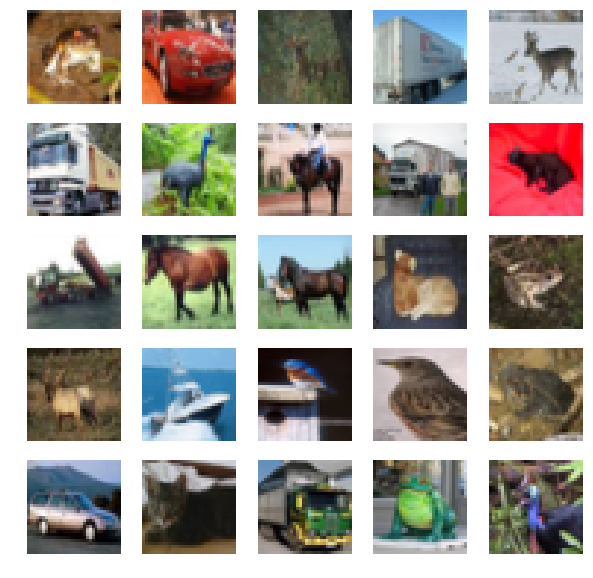

In [6]:
import matplotlib.pyplot as plt

fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(imgs[j+5*k])


## 4. kNN

In [10]:
import numpy as np

class kNN(object): # from Fei-Fei-Li, http://cs231n.github.io/classification/
    
    def __init__(self, k=1):
        self.k = k
    
    def train(self, X, y): 
        self.Xtr = X # X is N times D
        self.ytr = y # y is N times 1
    
    def predict(self, X): # X is M times D, each row needs a prediction
        num_test = X.shape[0]
        
        ypred = np.empty(num_test, dtype=self.ytr.dtype)
        
        for i in range(num_test):
            distance = np.sum(np.abs(self.Xtr-X[i,:]), axis=1)
            idx = np.argpartition(distance, self.k)[:self.k]
            # can take the average of the labels
            # ypred[i] = int(np.mean(self.ytr[idx]))
            # probably better to take the most frequent
            ypred[i] = np.bincount(self.ytr[idx]).argmax()
        
        return ypred 

# returns the best knn for k amonst klst
# when validated on data with data_size
def train_cifar(klst=[10, 25, 60, 90], data=DATA, data_size=1000):
    # cross-validation set
    cv_data = data[-2][b'data'][:data_size,:]
    label_type = cv_data.dtype
    cv_labels = np.array(data[-2][b'labels'][:data_size], dtype=label_type)
    errs = []
    knn = []
    
    for i in range(len(klst)):
        # construct kNN for k in klst        
        knn.append(kNN(klst[i])) 
        
        # train kNN
        knn[i].train(data[i+1][b'data'][:data_size,:], 
                     np.array(data[i+1][b'labels'][:data_size], dtype=label_type))
        
        # counting error 
        ypred = knn[i].predict(cv_data)
        errs.append(len(ypred[ypred != cv_labels])/len(cv_labels))
        
    # return the best knn
    i = np.argmin(errs)
        
    return knn, errs, i

knn, errs, i = train_cifar()
print(errs) # prints out validation error for each k in klst

[0.823, 0.818, 0.838, 0.838]


In [11]:
# the k=25 kNN is the best with the smallest error of 0.818
# this error is so bad, might as well just guess
test_data = DATA[-1][b'data']
test_label = DATA[-1][b'labels']
pred = knn[1].predict(test_data)

In [12]:
print(len(pred[pred != test_label])/len(test_label)) # test error when test on 10-Nearest-Neighbor

0.8206


In [ ]:
# evidently KNN is not a good way to classify images. The dimension of the problem is too large 
# making the expected distance between each input large with low variation.